In [2]:
import pandas as pd
from bc_power import utils
from bc_power import hydro
import dask
import xarray as xr # Need it for the aggregation of the normalized matrix...
import numpy as np
import geopandas as gpd
import atlite
import logging
from shapely.geometry import Point
from collections import namedtuple
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from cartopy.crs import PlateCarree as plate
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import xarray as xr
from scipy.sparse import csr_matrix, find
logging.basicConfig(level=logging.INFO)

### Load data

In [3]:
cfg = utils.load_config("/mnt/c/Users/pmcw9/Delta-E/PICS/PyPSA_BC/config/config.yaml")

In [4]:
# load cutout
cutout = atlite.Cutout(path=cfg["cutout"]["file"])

In [5]:
na_basin_data = hydro.load_hydro_basins(cfg["basin_files"]["na_file"])
ar_basin_data = hydro.load_hydro_basins(cfg["basin_files"]["artic_file"])
basin_data = gpd.GeoDataFrame(pd.concat([na_basin_data, ar_basin_data]))
# Loading in hydrobasins data takes: 1m 31.5

### Calls

In [6]:
# Removes the geometry column
meta = basin_data[basin_data.columns.difference(("geometry",))]

# Extracts the geometry (shapely polgon/multi-polygon)
shapes = basin_data["geometry"]

# Sites/plants which need inflow data.
sites = hydro.load_hydro_sites(cfg["generation"]["hydro_assets"]).groupby(by="asset_id",
        group_keys=False).apply(hydro.merge_assets)

# # Finds cutout cells nearest to (lat,lon) of each site 
# # (x,y) of cells/grids are the center points by default and correspong to (lat,lon) of the cells.
# nearest = cutout.data.sel(
#     {'x': sites.lon.values, 'y': sites.lat.values}, 'nearest').coords

# # Add new columns for the grid (x,y) where each generator falls.
# sites['x'] = nearest.get('x').values
# sites['y'] = nearest.get('y').values

In [111]:
# namedtupled
Basins = namedtuple("Basins", ["plants", "meta", "shapes"])

plant_basins = hydro.get_site_basins(sites, meta, shapes)

# Unique basins indices of all upstream (inclusive) basins
# Stores unique HIDs for based on all upstream basins
# Note: This is likely where a calculation for the difference of inflows
# could be made to account for the flows of downstream dams in a cascade.. (HERE to make modification...)
unique_basins = pd.Index(plant_basins["upstream"].sum()).unique().rename("hid")

# This is where return of the determine_basins would be 
# basins.plants, basins.meta, basins.shapes
basins = Basins(plant_basins, meta.loc[unique_basins], shapes.loc[unique_basins])

***Simple technique: $$sum_{j \in Cutout}(R_{basin,j}*A_{j}*\pi_{basin,j})= Q (\frac{m^3}{hr})$$***

In [112]:
# # index set before calling cutout.runoff()
# index = basins.shapes.index

# # Create indicators matrix:
# # columns represent the cutouts
# # rows represent the upstream basins
# # cell values indicates the ratio of cutout (j) area contained in the basin (i)
# matrix = cutout.indicatormatrix(basins.shapes)

# # UPDATE: Removed normalization added a diagonal matrix
# cutout_area_mat = csr_matrix(np.diag(gpd.GeoSeries(cutout.grid_cells(),crs=4326).to_crs(dict(proj="cea")).area))

# ## calculate runoff
# # Note: with or without height...
# runoff = cutout.data['runoff'] # Can multiply by cutout.data['height'] 

# # Normalzied matrix...
# matrix = csr_matrix(matrix)

# # Aggregate the matrix
# # HERE: Need to understand how the transformation makes sense
# # not clear why matrix is normalized and then why runoff is aggregated as a product of the normalized matrix
# # LOGIC missing...
# if isinstance(runoff.data, dask.array.core.Array):
#     da = runoff.stack(spatial=("y", "x")) # New dim which uses existing dims of (y,x)
#     result = xr.apply_ufunc(
#         lambda da: da * cutout_area_mat * matrix.T,
#         da,
#         input_core_dims=[["spatial"]],
#         output_core_dims=[[index.name]],
#         dask="parallelized",
#         output_dtypes=[da.dtype],
#         dask_gufunc_kwargs=dict(output_sizes={index.name: index.size}),
#     ).assign_coords(**{index.name: index})
# else:
#     print('In the else')
#     # da = runoff.stack(spatial=("y", "x")).transpose("spatial", "time")
#     # result = xr.DataArray(matrix_normalized * da, [index, da.coords["time"]])

# # runoff = runoff (assumed in meters uniformly spread across the cutout grid) * area (area of the basin (m^2)) 
# # NOTE: Removed (1000/24) conversion since it is dated.
# #UPDATE: no need to multiple by area of the basin now
# result.load()

# # Task: calling hydrom.shift_and_aggregate_runoff_for_plants(basins, runoff, flowspeed, show_progress)
# # Calculate set
# flowspeed = 1

# inflow = xr.DataArray(
#         np.zeros((len(basins.plants), result.indexes["time"].size)),
#         [("plant", basins.plants.index), result.coords["time"]],
#     )

# for ppl in basins.plants.itertuples():
#     # instantiate array for inflow to the plant
#     inflow_plant = inflow.loc[dict(plant=ppl.Index)]
#     # calculate distance from all upsteam basins to the current basin
#     # DIST_MAIN: Units in km
#     distances = (
#         basins.meta.loc[ppl.upstream, "DIST_MAIN"]
#         - basins.meta.at[ppl.hid, "DIST_MAIN"]
#     )
#     # Estimates time delay for inflow to reach the basin containing the power plant 
#     nhours = (distances / (flowspeed * 3.6) + 0.5).astype(int)

    
#     # Calculating the  timedelayed inflow at each plant
#     # The the offset is done by cyclic shift in hours
#     for b in ppl.upstream:
#         inflow_plant += result.sel(hid=b).roll(time=nhours.at[b]) # MODFIED += doesn't work...


***Atlite technique: $$R_{avg} * A_{basin} = Q (\frac{m^3}{hr})$$***

In [113]:
# index set before calling cutout.runoff()
index = basins.shapes.index

# Create indicators matrix:
# columns represent the cutouts
# rows represent the upstream basins
# cell values indicates the ratio/proportion of cutout (j) area contained in the basin (i)
matrix = cutout.indicatormatrix(basins.shapes)

# normalize the matrix ...
# normalizes the matrix based on the 
# cell values indicates the proportion of intersected area between cutout (j) and basin (i)
# w.r.t the total intersected areas of basin (i) with all cutouts (j)
matrix_normalized = matrix / matrix.sum(axis=1)

## calculate runoff
# Note: with or without height...
runoff = cutout.data['runoff'] # Can multiply by cutout.data['height']

# Normalzied matrix...
matrix_normalized = csr_matrix(matrix_normalized)

# Aggregate the matrix
# 
if isinstance(runoff.data, dask.array.core.Array):
    da = runoff.stack(spatial=("y", "x")) # New dim which uses existing dims of (y,x)
    result = xr.apply_ufunc(
        lambda da: da * matrix_normalized.T,
        da,
        input_core_dims=[["spatial"]],
        output_core_dims=[[index.name]],
        dask="parallelized",
        output_dtypes=[da.dtype],
        dask_gufunc_kwargs=dict(output_sizes={index.name: index.size}),
    ).assign_coords(**{index.name: index})
else:
    print(f'Runoff data is not in correct format, runoff data has {type(runoff.data)} type')
    exit(1)
    # da = runoff.stack(spatial=("y", "x")).transpose("spatial", "time")
    # result = xr.DataArray(matrix_normalized * da, [index, da.coords["time"]])

# runoff = runoff (assumed in meters uniformly spread across the cutout grid) * area (area of the basin (m^2)) 
# NOTE: Removed (1000/24) conversion since it is dated.
result *= xr.DataArray(basins.shapes.to_crs(dict(proj="cea")).area)
result.load()

# Task: calling hydrom.shift_and_aggregate_runoff_for_plants(basins, runoff, flowspeed, show_progress)
# Calculate set
flowspeed = 1

inflow = xr.DataArray(
        np.zeros((len(basins.plants), result.indexes["time"].size)),
        [("plant", basins.plants.index), result.coords["time"]],
    )

for ppl in basins.plants.itertuples():
    # instantiate array for inflow to the plant
    inflow_plant = inflow.loc[dict(plant=ppl.Index)]
    # calculate distance from all upsteam basins to the current basin
    # DIST_MAIN: Units in km
    distances = (
        basins.meta.loc[ppl.upstream, "DIST_MAIN"]
        - basins.meta.at[ppl.hid, "DIST_MAIN"]
    )
    # Estimates time delay for inflow to reach the basin containing the power plant 
    nhours = (distances / (flowspeed * 3.6) + 0.5).astype(int)

    # Aggregation of all basin flows (m^3/hr):
    # Calculating the  timedelayed inflow at each plant
    # The the offset is done by cyclic shift in hours
    for b in ppl.upstream:
        inflow_plant += result.sel(hid=b).roll(time=nhours.at[b]) # MODFIED += doesn't work...


In [114]:
output = inflow.to_pandas().T

In [115]:
output

plant,BC_ALH_GSS,BC_MCA_GSS,BC_REV_GSS,BC_WGS_GSS,BC_WHN_GSS
time,,,,,
2021-01-01 00:00:00,931845.158471,466804.627973,667857.922700,893473.371640,735838.412696
2021-01-01 01:00:00,931526.184670,466686.359895,667393.305523,894463.527645,733931.044588
2021-01-01 02:00:00,931813.374175,466558.154582,667180.291054,893788.215394,733973.456055
2021-01-01 03:00:00,932316.916245,466452.316442,667220.380306,893947.051308,733999.407587
2021-01-01 04:00:00,931825.564994,465120.986590,667151.298495,893558.290680,733419.232500
...,...,...,...,...,...
2021-12-31 19:00:00,932768.377729,467641.199514,668607.343304,895174.748574,738245.335599
2021-12-31 20:00:00,933408.945097,467178.879509,668373.653452,895531.373662,737717.792772
2021-12-31 21:00:00,933483.639491,467197.392225,667821.160821,895393.591191,737695.363902


In [117]:
sites

,connecting_node_code,num_of_units,lat,lon,capacity,capacity_factor,annual_avg_energy,nominal_head,max_spill,max_water_discharge,...,typical_plant_size_MW,capital_cost_USD_per_kW,service_life_years,fixed_om_cost_USD_per_MWyear,variable_om_cost_USD_per_MWh,average_fuel_price_USD_per_MMBtu,carbon_emissions_tCO2eq_per_MWh,start_year,closure_year,geometry
asset_id,,,,,,,,,,,,,,,,,,,,,
BC_ALH_GSS,BC_ALH_GSS,2,49.343024,-117.768849,186.0,DEFAULT,767.00,DEFAULT,37800000,1908000,...,100,2769,80,30371,1.86,0,0,2002,2042,None
BC_MCA_GSS,BC_MCA_GSS,6,52.075872,-118.570515,2972.0,DEFAULT,11695.88,DEFAULT,15444000,5724000,...,700,6700,100,10578,0.88,0,0,1976,2046,None
BC_REV_GSS,BC_REV_GSS,5,51.048563,-118.193945,2500.0,DEFAULT,8799.85,DEFAULT,25596000,4770000,...,700,6700,100,10578,0.88,0,0,1984,2054,None
BC_WGS_GSS,BC_WGS_GSS,1,49.910565,-118.071814,54.0,DEFAULT,156.65,DEFAULT,1004400,122400,...,100,2769,80,30371,1.86,0,0,1951,2021,None
BC_WHN_GSS,BC_WHN_GSS,2,50.813937,-118.060010,8.0,DEFAULT,23.20,DEFAULT,39600,14400,...,100,2769,80,30371,1.86,0,0,1960,2030,None


In [108]:
output = inflow.to_pandas().T
rho_w = 1000
g = 9.81
a = 1
power_series = output.copy()
for ind,row in sites.iterrows():
    # For each index 
    # energy_tot / inflow_series.sum
    # convery from GWh to MWh
    # initialize value for first points of evaluation
    const = row['annual_avg_energy'] * 1000 / output[ind].sum()
    for i in range(100):
        # Calculate power series based on const
        temp_series = output[ind].apply(lambda x: min(x*const,row['capacity']))
        # Calculate function value (this is what we are trying to get to zero)
        f = -row['annual_avg_energy'] * 1000 + temp_series.sum()
        if abs(f) <= 1e-4:
            power_series[ind] = temp_series
            break
        # Calculate derivative
        dfdc = output[ind].apply(lambda x: (x*const < row['capacity'])*x)
        # Perform newton method
        const = const - f / dfdc.sum()
        # conditon check
    if i == 100:
        print('Newton Method did not converge for RoR power series.')
        print(f'Final function value is {f}')
    
    

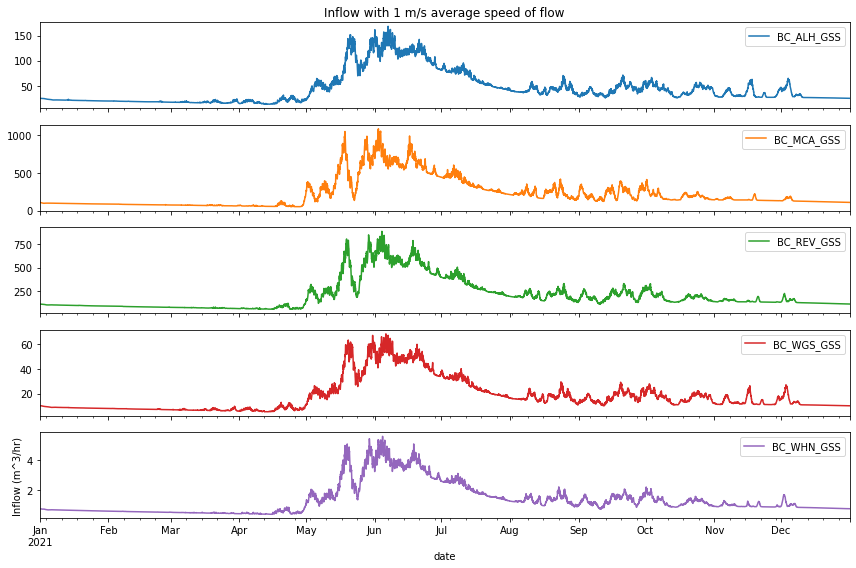

In [50]:
inflow_arr = output
# diff_arr = inflow_arr.iloc[:,1] - inflow_arr.iloc[:,0]
# inflow_arr['Revelstoke-Modified'] = diff_arr

# Plotting of the power generation
fig, axes = plt.subplots(inflow_arr.shape[1], sharex=True, figsize=(12, 8))
inflow_arr.plot(subplots=True, ax=axes)
axes[-1].set_xlabel('date')
axes[-1].set_ylabel('Inflow (m^3/hr)')
axes[0].set_title(f'Inflow with {flowspeed} m/s average speed of flow')
fig.tight_layout()

In [31]:
# out_path = '/mnt/c/Users/pmcw9/Delta-E/PICS/PyPSA_BC/results/interim/ror_raw_inflow.csv'
# inflow_arr.to_csv(out_path)

In [42]:
# a = pd.read_csv(out_path, index_col=["time"],parse_dates=["time"])

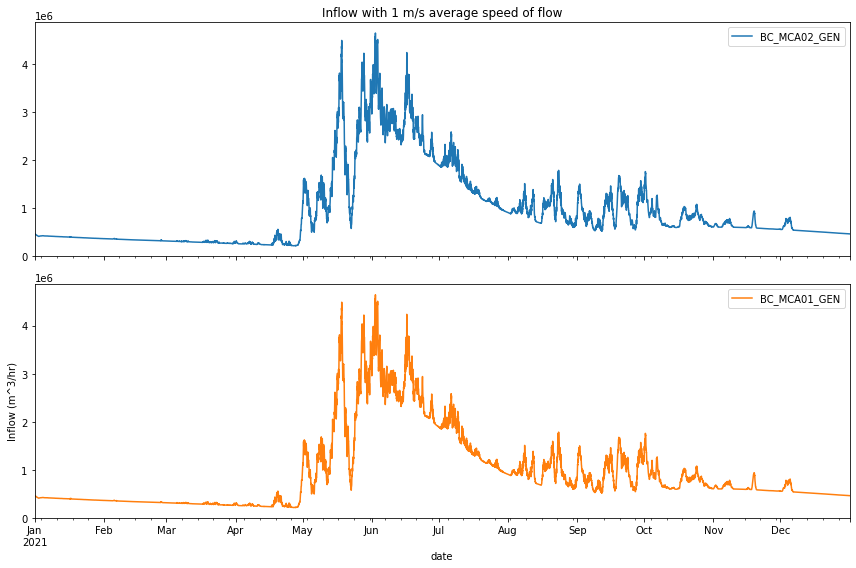

In [29]:
inflow_arr = inflow.to_pandas().T[["BC_MCA02_GEN","BC_MCA01_GEN"]]
# diff_arr = inflow_arr.iloc[:,1] - inflow_arr.iloc[:,0]
# inflow_arr['Revelstoke-Modified'] = diff_arr

# Plotting of the power generation
fig, axes = plt.subplots(inflow_arr.shape[1], sharex=True, figsize=(12, 8))
inflow_arr.plot(subplots=True, ax=axes)
axes[-1].set_xlabel('date')
axes[-1].set_ylabel('Inflow (m^3/hr)')
axes[0].set_title(f'Inflow with {flowspeed} m/s average speed of flow')
fig.tight_layout()
